In [ ]:
'''
import pip

for package in sorted(pip.get_installed_distributions(), key=lambda x: x.project_name):
    print("{} ({})".format(package.project_name, package.version))
'''

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.chdir("/kaggle/input/eegdata")

/kaggle/input/eegdata/y_test.npy
/kaggle/input/eegdata/main.py
/kaggle/input/eegdata/y_train_valid.npy
/kaggle/input/eegdata/person_train_valid.npy
/kaggle/input/eegdata/EEG_pl.py
/kaggle/input/eegdata/X_test.npy
/kaggle/input/eegdata/dataset.py
/kaggle/input/eegdata/EEG_loading.ipynb
/kaggle/input/eegdata/person_test.npy
/kaggle/input/eegdata/X_train_valid.npy
/kaggle/input/eegdata/classifier.py


### Shape of data

In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers

In [63]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left is 769 - 0
# Cue onset right is 770 - 1
# Cue onset foot is 771 - 2
# Cue onset tongue is 772 - 3

y_train_valid -= 769
y_test -= 769

In [5]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)


In [64]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (1772, 250, 1, 22)


In [69]:
y_test[10][0]

0.0

In [7]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=16, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22),kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))) # Output FC layer with softmax activation

# Printing the model summary
basic_cnn_model.summary()


2022-03-12 19:50:08.506236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:50:08.607193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:50:08.608354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 1, 16)        3536      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 1, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 1, 16)         64        
_________________________________________________________________
dropout (Dropout)            (None, 84, 1, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 1, 32)         5152      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 1, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 1, 32)         1

2022-03-12 19:50:08.610935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 19:50:08.611854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:50:08.612928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:50:08.613956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
# Model parameters
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-4
epochs = 200
cnn_optimizer = Adam(learning_rate=learning_rate)

In [9]:
# Compiling the model
from keras.callbacks import EarlyStopping

basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', patience=25)]

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=32,
             epochs=epochs,
             validation_data=(x_valid, y_valid),
             callbacks=callbacks,
             verbose=True)

2022-03-12 19:50:11.414038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-03-12 19:50:13.019005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


218/218 [==============================] - 9s 8ms/step - loss: 3.9769 - accuracy: 0.2701 - val_loss: 3.1665 - val_accuracy: 0.2860
Epoch 2/200
218/218 [==============================] - 1s 5ms/step - loss: 3.7351 - accuracy: 0.2957 - val_loss: 3.2223 - val_accuracy: 0.2993
Epoch 3/200
218/218 [==============================] - 1s 6ms/step - loss: 3.5976 - accuracy: 0.3122 - val_loss: 3.1057 - val_accuracy: 0.3233
Epoch 4/200
218/218 [==============================] - 1s 5ms/step - loss: 3.4636 - accuracy: 0.3190 - val_loss: 3.0289 - val_accuracy: 0.3427
Epoch 5/200
218/218 [==============================] - 1s 5ms/step - loss: 3.3655 - accuracy: 0.3289 - val_loss: 2.9791 - val_accuracy: 0.3487
Epoch 6/200
218/218 [==============================] - 1s 5ms/step - loss: 3.2811 - accuracy: 0.3424 - val_loss: 2.9238 - val_accuracy: 0.3740
Epoch 7/200
218/218 [==============================] - 1s 5ms/step - loss: 3.1897 - accuracy: 0.3576 - val_loss: 2.9363 - val_accuracy: 0.3520
Epoch 8/200

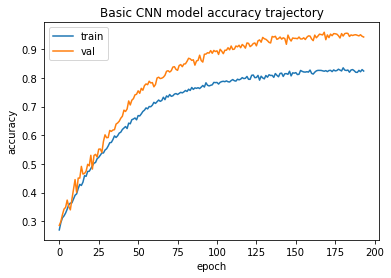

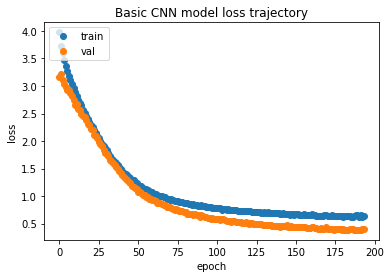

In [12]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7353273034095764


In [70]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_pred_test = basic_cnn_model.predict(x_test)


#classification_report
for i,x in enumerate(['left','right','foot','tongue']):
    print(x)
    y_pred = np.where(y_pred_test[:,i]>0.5,1,0)
    
    print(classification_report(y_test[:,i], y_pred))

left
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1328
         1.0       0.78      0.72      0.75       444

    accuracy                           0.88      1772
   macro avg       0.84      0.82      0.83      1772
weighted avg       0.88      0.88      0.88      1772

right
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      1264
         1.0       0.76      0.78      0.77       508

    accuracy                           0.87      1772
   macro avg       0.84      0.84      0.84      1772
weighted avg       0.87      0.87      0.87      1772

foot
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91      1388
         1.0       0.70      0.51      0.59       384

    accuracy                           0.85      1772
   macro avg       0.79      0.73      0.75      1772
weighted avg       0.84      0.85      0.84      1772

ton